<a href="https://colab.research.google.com/github/michelucci/O2T-Real-Data-Paper/blob/master/notebooks/o2t_data_preparation_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

This notebook has the goal of reading the data in the original format and put it in a more reasonable format (pandas). So that we could actually work with them.

Version 0.1 - 2.6.2019

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import walk

In [2]:
!pip install tensorflow-gpu
import tensorflow as tf

     |████████████████████████████████| 380.8MB 47kB/s 
     |████████████████████████████████| 3.8MB 29.3MB/s 
     |████████████████████████████████| 450kB 46.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [190]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
root_folder = "/content/drive/My Drive/data/O2T/"

## Functions

In [0]:
def read_data_file(name):
    d = {}
    with open(name, encoding="iso8859-1") as f:
        for line in f:
            if ("=" in line):
                (key, val) = line.split('=')
                d[key] = val
    return d

In [0]:
def print_dict(d):
    for key, val in d.items():
        print (key)
        print (val)
        print ("----")

In [0]:
def convert_dictionary(d):
    d_ = {'T': -1, 'O2': -1, 'iter':-1, 'freq':[0], 'data': [0]}
    d_['T'] = int(d['Temperature (°C)'].rstrip())
    d_['O2'] = int(d['Concentration O2Air (%)'].rstrip())
    d_['iter'] = int(d['Iterations'].rstrip())
    d_['freq'] = np.array(re.sub(r'\<.*\>', '', d['Frequency (Hz)']).rstrip().split(","))
    d_['data'] = np.array(re.sub(r'\<.*\>', '', d['Phi Comp (°)']).rstrip().split(",")).reshape(d_['iter'], d_['freq'].shape[0])
    
    d_['freq'] = [d_['freq']]
    d_['data'] = [d_['data']]
    
    p = pd.DataFrame.from_dict(d_)
    return p

In [0]:
def generate_dataframe_from_directory(path):
    df = pd.DataFrame()

    for (dirpath, dirnames, filenames) in walk(path):
        for filename in filenames:
            # Read the files
            if (filename.lower().endswith('txt') and filename.lower().startswith('temp')):
                #print('Reading '+filename)
                d = read_data_file(root_folder+filename)
                p = convert_dictionary(d)
                df = df.append(p)
                
    return df

## Study and test data format

In [9]:
d = read_data_file(root_folder + "Reference.txt")
print_dict(d)

MGI RWA Section Options
2.0.1 %04Y%02m%02d %02H%02M%S%25u*~|.%d*~|.,*~|.%#_13g

----
File
C:\Projekte\LuminescenceAI\RealProbe5mm\Data\Temp_25deg_Conc_100perc.txt

----
Date, Time
26.04.2019, 12:52

----
Temperature (°C)
25

----
Concentration O2Air (%)
100

----
Iterations
1

----
Frequency (Hz)
<50>200,300,400,500,600,700,800,900,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750,7000,7250,7500,7750,8000,8250,8500,8750,9000,9250,9500,9750,10000,11000,12000,13000,14000,15000

----
Phi Comp (°)
<50>-0.354,-0.57,-0.786,-0.99,-1.194,-1.404,-1.602,-1.8,-1.998,-2.502,-3,-3.51,-4.002,-4.506,-5.016,-5.508,-6.012,-6.516,-7.014,-7.512,-8.004,-8.502,-9,-9.492,-9.984,-10.482,-10.974,-11.466,-11.952,-12.444,-12.93,-13.416,-13.902,-14.388,-14.874,-15.36,-15.84,-16.32,-16.8,-17.274,-17.754,-18.234,-18.702,-19.176,-19.644,-21.522,-23.37,-25.2,-26.994,-28.776

----
R (V)
<50>0.298922,0.298952,0.298983,0.298922,0.298861,0.29883

In [0]:
d = read_data_file(root_folder + "Temp_5deg_Conc_0perc.txt")
d = convert_dictionary(d)

## Load the reference file

We load now the reference file. This needs to be subtracted by all other measurements.

In [0]:
ref = read_data_file(root_folder + "Reference.txt")
ref = convert_dictionary(ref)
ref_data = ref.data[0].astype(np.float)

# Loop over files in the directory

In [0]:
df = generate_dataframe_from_directory(root_folder)

In [13]:
df.head()

,T,O2,iter,freq,data
0,5,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.83, -7.23, -9.594, -11.922, -14.202, -16...."
0,5,10,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-3.714, -5.562, -7.398, -9.204, -10.998, -12..."
0,5,15,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-3.402, -5.106, -6.786, -8.46, -10.092, -11...."
0,5,20,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-3.174, -4.746, -6.318, -7.866, -9.402, -10...."
0,5,5,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.122, -6.168, -8.19, -10.194, -12.174, -14..."


In [29]:
df.data[0].iloc[0]

df.data[0]

0    [[-4.83, -7.23, -9.594, -11.922, -14.202, -16....
0    [[-3.714, -5.562, -7.398, -9.204, -10.998, -12...
0    [[-3.402, -5.106, -6.786, -8.46, -10.092, -11....
0    [[-3.174, -4.746, -6.318, -7.866, -9.402, -10....
0    [[-4.122, -6.168, -8.19, -10.194, -12.174, -14...
                           ...                        
0    [[-1.626, -2.436, -3.246, -4.056, -4.854, -5.6...
0    [[-1.446, -2.184, -2.916, -3.636, -4.338, -5.0...
0    [[-1.41, -2.136, -2.838, -3.546, -4.248, -4.93...
0    [[-1.386, -2.082, -2.766, -3.462, -4.146, -4.8...
0    [[-1.362, -2.034, -2.7, -3.384, -4.044, -4.704...
Name: data, Length: 189, dtype: object

# Creation of the dataframe with just values for [O2]=0 % air

__note__: we will average the 20 measurements into one and use that to divide the other data.

In [86]:
df_zero = df[df['O2'] == 0]
df_zero

,T,O2,iter,freq,data
0,5,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.83, -7.23, -9.594, -11.922, -14.202, -16...."
0,10,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.728, -7.062, -9.372, -11.646, -13.884, -1..."
0,15,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.626, -6.918, -9.174, -11.406, -13.59, -15..."
0,20,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.53, -6.768, -8.988, -11.172, -13.32, -15...."
0,25,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.428, -6.63, -8.796, -10.95, -13.056, -15...."
0,30,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.338, -6.492, -8.616, -10.716, -12.78, -14..."
0,35,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.242, -6.354, -8.43, -10.5, -12.516, -14.5..."
0,40,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.146, -6.21, -8.25, -10.26, -12.252, -14.1..."
0,45,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.05, -6.078, -8.07, -10.038, -11.982, -13...."


Now we can average for each values of $T$ the 20 measurements contained into `data`

In [101]:
average_data = []
for index, row in df_zero.iterrows():
  #print(np.array(row['data']))
  avg_ = np.mean(np.array(row['data']).astype(np.float), axis = 0)
  #print(avg_)
  average_data.append(avg_)

df_zero['average'] = average_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
df_zero.head()

,T,O2,iter,freq,data,average
0,5,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.83, -7.23, -9.594, -11.922, -14.202, -16....","[-4.836899999999999, -7.229700000000001, -9.59..."
0,10,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.728, -7.062, -9.372, -11.646, -13.884, -1...","[-4.724099999999998, -7.064099999999999, -9.37..."
0,15,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.626, -6.918, -9.174, -11.406, -13.59, -15...","[-4.6248000000000005, -6.916800000000004, -9.1..."
0,20,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.53, -6.768, -8.988, -11.172, -13.32, -15....","[-4.5288, -6.7734, -8.991299999999999, -11.179..."
0,25,0,20,"[200, 300, 400, 500, 600, 700, 800, 900, 1000,...","[[-4.428, -6.63, -8.796, -10.95, -13.056, -15....","[-4.432199999999999, -6.632399999999999, -8.80..."


# Transformation of the dataframe

Now we need to create two numpy arrays. One with the "expected values" containing $T$ and $O2$ and one with all the measurements.

We have a certain amount of iterations contained in the column `iter` therefore we will need do duplicate the values of $T$ and $O2$ `iter` times.

In [143]:
x = df.iloc[0]['freq'].astype(np.float)
x

array([  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.])

In [142]:
'targets = []
train_data = []
for index, row in df.iterrows():
  list_ = [[row['T'], row['O2']]]*row['iter']
  #print(np.array(list_).shape)
  targets.extend(list_)

  # Then we need to create a list with all the measurements. 
  # There are row['iter'] of them.
  data_ = row['data'] # Shape (20,50)
  assert (data_.shape) == (row['iter'], len(row.freq)), "Size mismatch."
  
  for i in range(0, row['iter']):
    train_data.append(data_[i])

train_data_np = np.array(train_data).astype(np.float)
train_targets_np = np.array(targets).astype(np.float)

print(train_data_np.shape)
print(train_targets_np.shape)

(3780, 50)
(3780, 2)


In [151]:
# quick check to see how the data looks like. So far so good.
train_data_np[0]

array([ -4.83 ,  -7.23 ,  -9.594, -11.922, -14.202, -16.44 , -18.618,
       -20.736, -22.788, -27.63 , -32.046, -36.03 , -39.63 , -42.864,
       -45.768, -48.396, -50.76 , -52.89 , -54.828, -56.586, -58.194,
       -59.664, -61.002, -62.244, -63.384, -64.434, -65.418, -66.324,
       -67.17 , -67.95 , -68.688, -69.378, -70.026, -70.638, -71.214,
       -71.754, -72.264, -72.75 , -73.206, -73.644, -74.052, -74.442,
       -74.82 , -75.174, -75.516, -76.722, -77.754, -78.63 , -79.386,
       -80.046])

In [84]:
train_targets_np[0]

array([5., 0.])

# Subtracting the reference

Now let's first subtract the reference.

In [0]:
for i in range (train_data_np.shape[0]):
  train_data_np[i] = train_data_np[i] - ref_data

# diving by the values at 0 %

In [108]:
print(df_zero['average'].iloc[0])

[ -4.8369  -7.2297  -9.594  -11.9247 -14.2095 -16.4418 -18.6228 -20.7408
 -22.7976 -27.6357 -32.0511 -36.0372 -39.6381 -42.8721 -45.7737 -48.4029
 -50.7621 -52.8975 -54.8355 -56.5935 -58.2027 -59.6712 -61.0116 -62.2533
 -63.3939 -64.4454 -65.424  -66.3297 -67.1757 -67.9602 -68.6994 -69.3885
 -70.0353 -70.6458 -71.2182 -71.7591 -72.267  -72.7542 -73.2078 -73.6461
 -74.0538 -74.4444 -74.8224 -75.1773 -75.519  -76.7265 -77.754  -78.6324
 -79.3923 -80.0517]


In [174]:
print(df_zero[(df_zero['T'] == 10)]['average'].iloc[0])

[ -4.7241  -7.0641  -9.3771 -11.6538 -13.8894 -16.0752 -18.2106 -20.292
 -22.3092 -27.0684 -31.419  -35.3547 -38.9226 -42.1329 -45.0192 -47.637
 -49.992  -52.1295 -54.0684 -55.833  -57.4467 -58.926  -60.2736 -61.5258
 -62.6766 -63.7377 -64.7244 -65.643  -66.4953 -67.2909 -68.0385 -68.7381
 -69.3933 -70.0116 -70.596  -71.1426 -71.6604 -72.1524 -72.615  -73.0596
 -73.4745 -73.8732 -74.2569 -74.6184 -74.9631 -76.1961 -77.2464 -78.144
 -78.9216 -79.5969]


In [171]:
print(train_data_np[1])

[ -4.836  -7.23   -9.594 -11.922 -14.214 -16.44  -18.618 -20.736 -22.794
 -27.636 -32.046 -36.036 -39.63  -42.864 -45.768 -48.396 -50.754 -52.89
 -54.828 -56.586 -58.194 -59.664 -61.008 -62.25  -63.39  -64.44  -65.418
 -66.324 -67.17  -67.956 -68.694 -69.384 -70.032 -70.644 -71.214 -71.754
 -72.264 -72.75  -73.206 -73.644 -74.052 -74.442 -74.82  -75.174 -75.516
 -76.722 -77.754 -78.636 -79.392 -80.046]


In [0]:
train_data_norm = []

for i in range (train_data_np.shape[0]):
  # for each values of T and O2 identify the right dataset

  T_ = train_targets_np[i][0]
  zero_ = df_zero[(df_zero['T'] == T_)].iloc[0]
  

  #res_ = np.divide(train_data_np[i], zero_['average'])
  res_ = np.divide(zero_['average'], train_data_np[i])
  
  train_data_norm.append(res_)
  

train_data_norm_np = np.array(train_data_norm)
#print(train_data_norm_np.shape)
#print(train_data_norm_np[0])
#print(train_data_np[0])

Now let's print one to check how it looks like.

In [181]:
train_data_norm_np[23]

array([1.30024194, 1.3012419 , 1.29894395, 1.29644488, 1.2934189 ,
       1.28894638, 1.28468543, 1.28077066, 1.27588986, 1.26363512,
       1.25072583, 1.23762621, 1.22453197, 1.21210348, 1.20027533,
       1.18931889, 1.17897854, 1.16941902, 1.16053968, 1.15238241,
       1.14486605, 1.13776456, 1.1314788 , 1.12545287, 1.12007315,
       1.1150109 , 1.1102739 , 1.10582675, 1.10185513, 1.09808047,
       1.09453207, 1.09132302, 1.08824818, 1.08518894, 1.08250798,
       1.07999368, 1.07761474, 1.07535474, 1.07320785, 1.07115368,
       1.06915281, 1.06739504, 1.06575506, 1.06389997, 1.06251055,
       1.05701356, 1.05237941, 1.04851588, 1.04510307, 1.04242128])

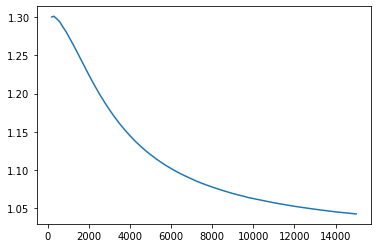

In [182]:
plt.plot(x, train_data_norm_np[23])
plt.show()

# Save the data

## Save data

In [0]:
np.savetxt(root_folder + 'train_data.csv', train_data_norm_np, delimiter=',')

In [191]:
!ls /content/drive/

'My Drive'


## Save targets

In [0]:
np.savetxt(root_folder + 'train_targets.csv', train_targets_np, delimiter=',')

In [195]:
x

array([  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.])